In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

Defining the Model

In [2]:
class LinearRegressionScratch(d2l.Module): #@save
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

In [3]:
# Define model to relate input and parameters to output
@d2l.add_to_class(LinearRegressionScratch) #@save
def forward(self, X):
    return torch.matmul(X, self.w) + self.b

Defining the Loss Function

In [8]:
@d2l.add_to_class(LinearRegressionScratch) #@save
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return l.mean()

Defining the Optimization Algorithm

In [10]:
class SGD(d2l.HyperParameters): #@save
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()
    def step(self):
        for param in self.params:
            param -= self.lr * param.grad
    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [11]:
# Define the configure_optimizers method
@d2l.add_to_class(LinearRegressionScratch) #@save
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

Training

In [12]:
@d2l.add_to_class(d2l.Trainer) #@save
def prepare_batch(self, batch):
    return batch

In [13]:
@d2l.add_to_class(d2l.Trainer) #@save
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0: # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

Generate Dataset

In [14]:
class SyntheticRegressionData(d2l.DataModule): #@save
    """Synthetic data for linear regression."""
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, len(w))
        noise = torch.randn(n, 1) * noise
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise

In [15]:
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)

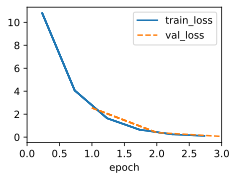

In [16]:
model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

In [17]:
print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([ 0.1582, -0.2073], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.2433], grad_fn=<RsubBackward1>)


### Concise Implementation

In [1]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

Define Model

In [2]:
class LinearRegression(d2l.Module): #@save
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

In [3]:
# Invoke the built-in __call__ method of the predefined layers to compute the outputs
@d2l.add_to_class(LinearRegression) #@save
def forward(self, X):
    return self.net(X)

Defining Loss Function

In [4]:
@d2l.add_to_class(LinearRegression) #@save
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

Define the Optimization Algorithm

In [5]:
@d2l.add_to_class(LinearRegression) #@save
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

Training

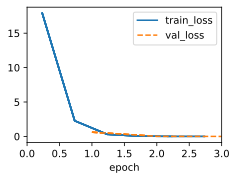

In [6]:
model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

In [7]:
@d2l.add_to_class(LinearRegression) #@save
def get_w_b(self):
    return (self.net.weight.data, self.net.bias.data)
w, b = model.get_w_b()

In [8]:
print(f'error in estimating w: {data.w - w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - b}')

error in estimating w: tensor([ 0.0014, -0.0074])
error in estimating b: tensor([0.0124])


### Weight Decay

In [9]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

High-Dimensional Linear Regression

In [10]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise
        
    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

### Implementation of Weight Decay from Scratch

Defining ℓ2 Norm Penalty

In [11]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

In [12]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()
    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +
            self.lambd * l2_penalty(self.w))

In [13]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

Training without Regularization

L2 norm of w: 0.011578662320971489


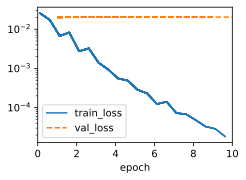

In [14]:
# Run code without decay
train_scratch(0)

Using Weight Decay

L2 norm of w: 0.001826993771828711


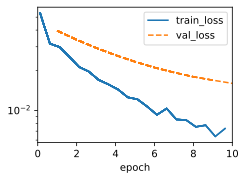

In [15]:
train_scratch(3)

### Concise Implementation

In [16]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd
        
    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)

L2 norm of w: 0.013809757307171822


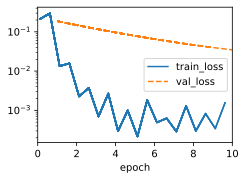

In [17]:
model = WeightDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))